1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


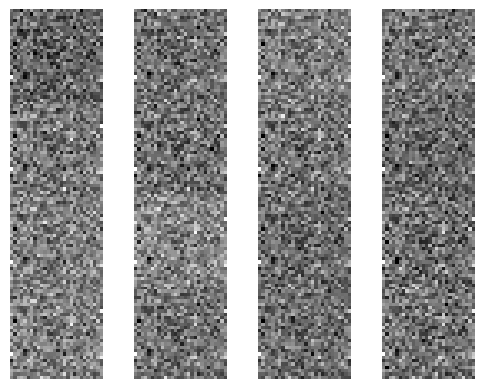

----------- EPOCH 59 -----------
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 0.2358
Epoch 1/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - loss: 0.0492 - val_loss: 0.0410
Epoch 2/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0475 - val_loss: 0.0389
Epoch 3/3
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0463 - val_loss: 0.0377
Test Loss: 0.037919946014881134
Pixel-wise Accuracy: 0.92188125
Model saved at: e:\deep cnn image classifier\data\DLPrac\autoencoder_mnist.keras


In [5]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, LeakyReLU as LR, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import os


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
plt.imshow(x_train[0], cmap="gray")
plt.show()
LATENT_SIZE = 32
encoder = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(64),
    LR(),
    Dropout(0.5),
    Dense(LATENT_SIZE),
    LR()
])
decoder = Sequential([
    Dense(64, input_shape=(LATENT_SIZE,)),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(784),
    Activation("sigmoid"),
    Reshape((28, 28))
])
img = Input(shape=(28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
model = Model(inputs=img, outputs=output)
model.compile("nadam", loss="binary_crossentropy")
model.summary()
EPOCHS = 60
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 
28, 28))
    display.clear_output()
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap="gray")
            axs[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
model.fit(x_train, x_train)


# 1) Prepare inputs to match encoder's expected input shape
def _prep_inputs(X, enc_input_shape):
    # enc_input_shape excludes batch, e.g., (784,) or (28, 28) or (28, 28, 1)
    if enc_input_shape is None:
        # Fallback: flatten
        return X.reshape((X.shape[0], -1)).astype("float32")
    if len(enc_input_shape) == 1:
        # Flatten images if needed
        return X.reshape((X.shape[0], -1)).astype("float32")
    elif len(enc_input_shape) == 2:
        # Expecting (H, W)
        return X.astype("float32")
    elif len(enc_input_shape) == 3:
        # Expecting (H, W, C)
        if X.ndim == 3:
            return X[..., None].astype("float32")
        return X.astype("float32")
    else:
        # Unexpected rank: fallback to flatten
        return X.reshape((X.shape[0], -1)).astype("float32")

# Derive encoder input shape (without batch)
try:
    enc_input_shape = tuple(encoder.input_shape[1:]) if hasattr(encoder, "input_shape") else None
except Exception:
    enc_input_shape = None

x_train_in = _prep_inputs(x_train, enc_input_shape)
x_test_in  = _prep_inputs(x_test, enc_input_shape)

# 2) Build the full autoencoder = encoder ∘ decoder
from tensorflow.keras.models import Sequential
autoencoder = Sequential([encoder, decoder])

# 3) Compile (required before fit/evaluate)
autoencoder.compile(optimizer="adam", loss="mse")

# 4) Train briefly (CPU-friendly)
history = autoencoder.fit(
    x_train_in, x_train_in,
    validation_split=0.1,
    epochs=3,            # keep it small for CPU
    batch_size=256,
    verbose=1
)

# 5) Evaluate
test_loss = autoencoder.evaluate(x_test_in, x_test_in, verbose=0)
print("Test Loss:", float(test_loss))

# 6) Pixel-wise accuracy (coarse, thresholded)
recon = autoencoder.predict(x_test_in, verbose=0)

def _to_compare(A, ref):
    """Reshape/squeeze A to compare with original ref images (x_test)."""
    if A.ndim == 4 and A.shape[-1] == 1:
        A = A[..., 0]
    if ref.ndim == 3 and A.ndim == 2:
        A = A.reshape(ref.shape[0], -1)  # keep flat if ref later flattened
    return A

recon_cmp = _to_compare(recon, x_test)
orig_cmp  = _to_compare(x_test_in, x_test)

# If inputs were flattened, flatten the original too for fair comparison
if orig_cmp.ndim == 2 and recon_cmp.ndim == 2:
    orig_bin  = (x_test.reshape(orig_cmp.shape) > 0.5).astype(np.float32)
    recon_bin = (recon.reshape(orig_cmp.shape) > 0.5).astype(np.float32)
else:
    orig_bin  = (x_test > 0.5).astype(np.float32)
    recon_bin = (recon_cmp > 0.5).astype(np.float32)

pixel_acc = float((orig_bin == recon_bin).mean())
print("Pixel-wise Accuracy:", pixel_acc)

# 7) Save the trained autoencoder
save_path = "autoencoder_mnist.keras"
autoencoder.save(save_path)
print(f"Model saved at: {os.path.abspath(save_path)}")
